# Image Classification with PyTorch (CIFAR-10)
This notebook contains a simple CNN classifier trained on CIFAR-10 dataset.

In [16]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [4]:
# Load CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

classes = trainset.classes

100%|████████████████████████████████████████████████████████████████████████████████| 170M/170M [03:40<00:00, 775kB/s]


In [5]:
# Define CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
# Set device and init model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = SimpleCNN().to(device)

In [7]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [8]:
# Train the model
train_loss_history = []
for epoch in range(3):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(trainloader)
    train_loss_history.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")
print('Finished Training')

Epoch 1, Loss: 1.3277
Epoch 2, Loss: 0.9504
Epoch 3, Loss: 0.7974
Finished Training


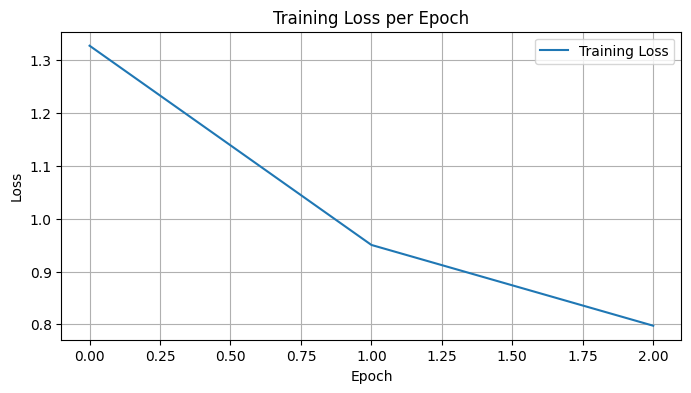

In [10]:
# Plot loss
plt.figure(figsize=(8,4))
plt.plot(train_loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

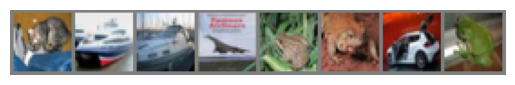

Ground Truth: cat ship ship airplane frog frog automobile frog
Predicted   : cat ship ship ship frog frog automobile frog


In [11]:
# Visualize predictions
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
outputs = net(images)
_, predicted = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images[:8].cpu()))
print('Ground Truth:', ' '.join(classes[labels[j]] for j in range(8)))
print('Predicted   :', ' '.join(classes[predicted[j]] for j in range(8)))

In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 69.59%


In [13]:
# Save model weights to file
torch.save(net.state_dict(), "simple_cnn_cifar10.pth")
print("Model saved successfully ✅")


Model saved successfully ✅


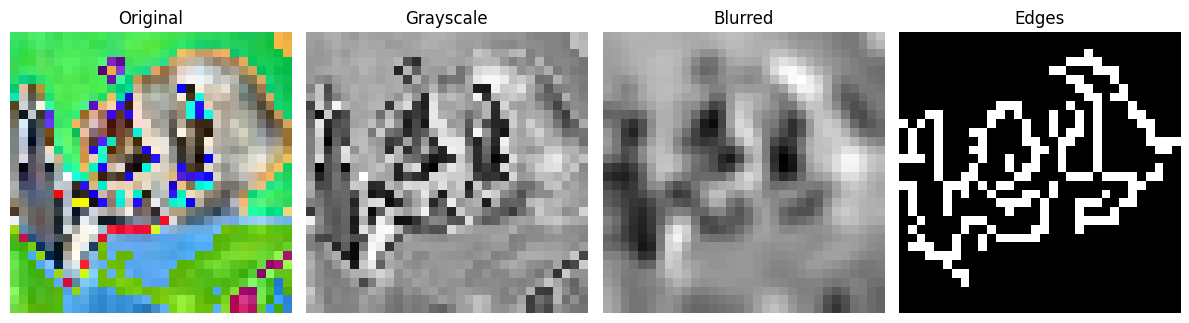

In [19]:
from torchvision.utils import make_grid

# Take one image from the test dataset
img_tensor = testset[0][0]  # take image only (without label)
img_np = img_tensor.numpy().transpose(1, 2, 0)  # convert from (C, H, W) → (H, W, C)
img_np = (img_np * 255).astype(np.uint8)  # reverse normalization to get original pixel values

# Convert RGB to BGR 
img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

# Convert to Grayscale
gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply Canny Edge Detection
edges = cv2.Canny(blurred, 100, 200)

# Visualization
plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(gray, cmap='gray')
plt.title("Grayscale")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(blurred, cmap='gray')
plt.title("Blurred")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(edges, cmap='gray')
plt.title("Edges")
plt.axis('off')

plt.tight_layout()
plt.show()

